Load Essential Libraries

In [46]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

%matplotlib inline

Download Dataset

In [47]:
# Download data
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

Load Train Data

In [48]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 0
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
291,95181,@JLJeffLewis @AmericanAir no excuse for lost l...,0
755,20845,I thought airport wi-fi was ridiculous until I...,0
2096,32473,@DanniAllen14 @united @RunLikeAGirl_ca @just_t...,1
432,165082,My @united flight to LA had no electricity for...,0
479,37552,Poop. _@stevethebikeguy: @JetBlue announces ne...,0


Split text into 2 categories : 90% training and 10% validation

In [49]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

Load Test Data : only about 300 tweets are non-complaining

In [50]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
1502,58081,@theJMcCray Unfortunately flight prices have s...
3572,134867,Ugh trying to get info on the @Delta website i...
4110,156758,@united Nothing like being on hold for 30 minu...
2586,98990,.@united far too many avoidable fails from ATL...
1739,67130,"Apparently bags are en route, but having to wa..."


Set up GPU for Training

In [51]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


TF-IDF + Naive Bayes Classifier

Preprocessing

In [52]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TF-IDF Vectorizer : is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus

In [53]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 9.6 s, sys: 1.32 s, total: 10.9 s
Wall time: 16.2 s


Train Naive Bayes Classifier

Hyperparameter Tuning

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):

    # Return the average AUC score from cross-validation.

    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

MultinominalNB will help us find the alpha value that gives us the highest CV AUC score

Best alpha:  1.3


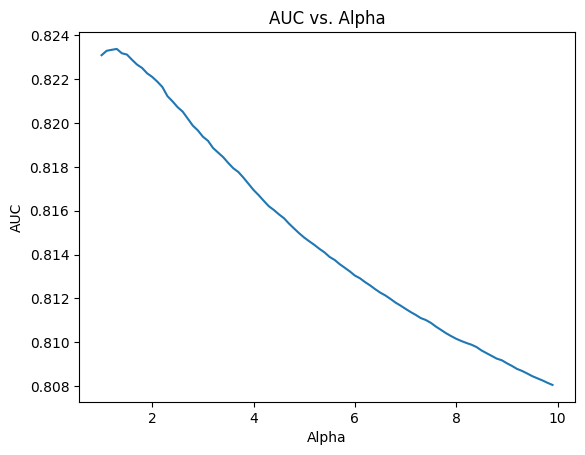

In [55]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha=i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

Evaluation on Validation Set : AUC ACCURACY AND RECALL

AUC: 0.8451
Accuracy: 75.59%
Recall: 69.64%


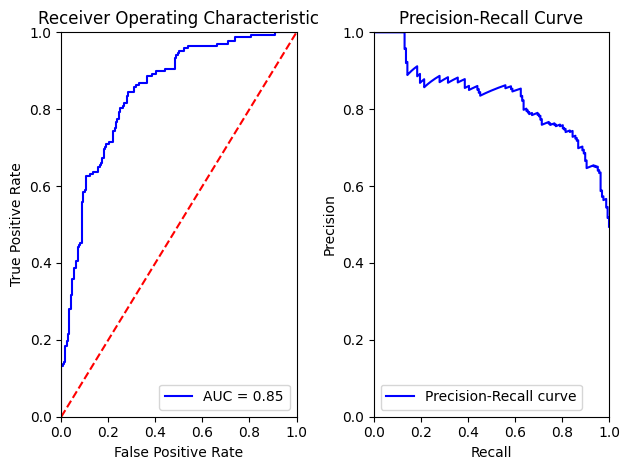

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, precision_recall_curve

def evaluate_performance(probs, y_true):
    """
    - Print AUC, accuracy, and recall on the test set
    - Plot ROC and precision-recall curves
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, threshold_roc = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Convert predicted probabilities to binary predictions (0 or 1) based on a threshold of 0.5
    y_pred = np.where(preds >= 0.5, 1, 0)

    # Calculate and print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Calculate and print recall
    recall = recall_score(y_true, y_pred)
    print(f'Recall: {recall*100:.2f}%')

    # Plot ROC AUC
    plt.subplot(1, 2, 1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # Calculate precision-recall curve
    precision, recall, threshold_pr = precision_recall_curve(y_true, preds)

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

# Assuming X_train_tfidf, y_train, X_val_tfidf, and y_val are defined
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_performance(probs, y_val)


Tokenization and Input Formatting

In [57]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


BERT Tokenizer


Specify the maximum length of our sentences

Tokenization

In [58]:
from transformers import BertTokenizer

MAX_LEN = 64

# Create a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function for preprocessing with padding
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
                            max_length=MAX_LEN,        # Pad & truncate all sentences.
                            return_attention_mask=True, # Construct attention masks.
                            return_tensors='np',       # Return numpy arrays.
                       )

        # Add the encoded sentence to the list.
        input_id = encoded_dict['input_ids'].squeeze()
        attention_mask = encoded_dict['attention_mask'].squeeze()

        # Pad the sequences to MAX_LEN
        pad_length = MAX_LEN - len(input_id)
        input_id = np.pad(input_id, (0, pad_length), 'constant', constant_values=0)
        attention_mask = np.pad(attention_mask, (0, pad_length), 'constant', constant_values=0)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)

    # Convert the lists into numpy arrays.
    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)

    return input_ids, attention_masks

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0][0])
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Token IDs:  [101, 1030, 2142, 1045, 1005, 1049, 2383, 3314, 1012, 7483, 1045, 2128, 8654, 2098, 2005, 2484, 2847, 2044, 1045, 2001, 4011, 2000, 4875, 1010, 2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 23713, 1025, 4638, 1999, 1012, 2064, 2017, 2393, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


Create PyTorch DataLoader

In [59]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32


# Create the DataLoader for our training set
train_data = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_masks), train_labels)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for our validation set
val_data = TensorDataset(torch.tensor(val_inputs), torch.tensor(val_masks), val_labels)

val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)




Train Our Model

Create BertClassifier

In [60]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 97 µs, sys: 0 ns, total: 97 µs
Wall time: 61.3 µs


Optimizer & Learning Rate Scheduler

In [61]:
from transformers import AdamW, get_linear_schedule_with_warmup


def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(bert_classifier.parameters(),
                                  lr=5e-5,    # Default learning rate
                                  eps=1e-8    # Default epsilon value
                                  )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Training Loop : 4 epochs

Training:

Unpack our data from the dataloader and load the data onto the GPU

Zero out gradients calculated in the previous pass

Perform a forward pass to compute logits and loss

Perform a backward pass to compute gradients (loss.backward())

Clip the norm of the gradients to 1.0 to prevent "exploding gradients"

Update the model's parameters (optimizer.step())

Update the learning rate (scheduler.step())

Evaluation:

Unpack our data and load onto the GPU

Forward pass

Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop.

In [62]:
import random
import time


# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    # Set seed for reproducibility.
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")

    for epoch_i in range(epochs):
    # =======================================
    #               Training
    # =======================================
    # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        # Put the model into the training mode
        model.train()

        # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        batch_counts +=1
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Zero out any previously calculated gradients
        model.zero_grad()
        # Perform a forward pass. This will return logits.
        logits = model(b_input_ids, b_attn_mask)
        # Compute loss and accumulate the loss values
        loss = loss_fn(logits, b_labels)
        batch_loss += loss.item()
        total_loss += loss.item()
        # Perform a backward pass to calculate gradients
        loss.backward()
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()
        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Calculate time elapsed for 20 batches
            time_elapsed = time.time() - t0_batch
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0
            t0_batch = time.time()
            # Calculate the average loss over the entire training data
            avg_train_loss = total_loss / len(train_dataloader)
            print("-"*70)
    # =======================================
    #               Evaluation
    # =======================================
    if evaluation == True:
        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        val_loss, val_accuracy = evaluate(model, val_dataloader)
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
        print("\n")
        print("Training complete!")
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    # Tracking variables
    all_val_accuracy = []
    all_val_loss = []
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss
            loss = loss_fn(logits, b_labels)
            all_val_loss.append(loss.item())
            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()
            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            all_val_accuracy.append(accuracy)
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(all_val_loss)
    val_accuracy = np.mean(all_val_accuracy)
    return val_loss, val_accuracy

# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

Training BertClassifier

In [63]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.653223   |     -      |     -     |   7.22   
----------------------------------------------------------------------
   2    |   40    |   0.567368   |     -      |     -     |   7.19   
----------------------------------------------------------------------
   2    |   60    |   0.470364   |     -      |     -     |   7.20   
----------------------------------------------------------------------
   2    |   80    |   0.468591   |     -      |     -     |   7.07   
----------------------------------------------------------------------
   2    |   95    |   0.469919   |     -      |     -     |   5.20   
-----------------------------------------------------------------

Evaluation on Validation Set

ROC AUC: 0.9611
Accuracy: 88.82%
Recall: 82.74%


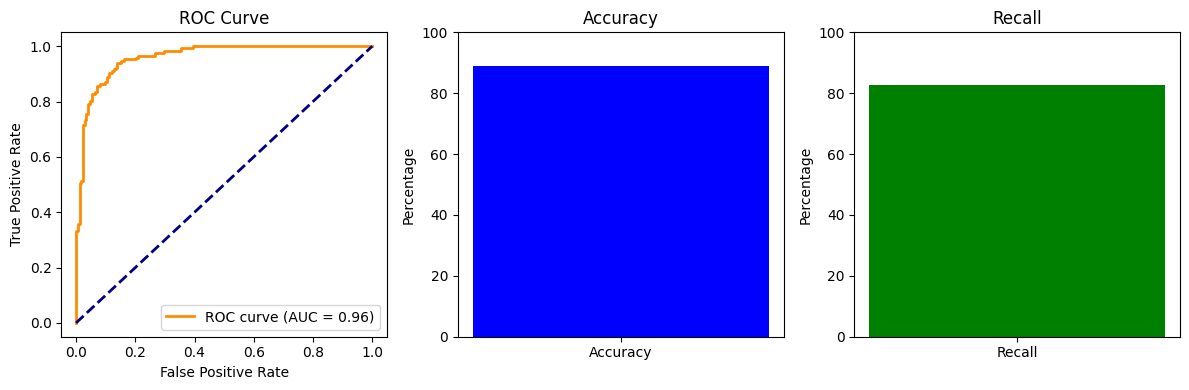

In [88]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Assuming y_val is a 1D array with binary labels (0 or 1)
true_labels = y_val

# Evaluate the ROC AUC score
roc_auc = roc_auc_score(true_labels, probs[:, 1])  # Assuming probs contains probabilities for the positive class
print(f'ROC AUC: {roc_auc:.4f}')

from sklearn.metrics import accuracy_score, recall_score

# Threshold for converting probabilities to binary predictions
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
binary_predictions = (probs[:, 1] > threshold).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(true_labels, binary_predictions)
accuracy_percentage = accuracy * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

# Evaluate recall
recall = recall_score(true_labels, binary_predictions)
recall_percentage = recall * 100
print(f'Recall: {recall_percentage:.2f}%')

# Plot ROC AUC
fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.bar(['Accuracy'], [accuracy_percentage], color=['blue'])
plt.ylim(0, 100)
plt.ylabel('Percentage')
plt.title('Accuracy')

# Plot recall
plt.subplot(1, 3, 3)
plt.bar(['Recall'], [recall_percentage], color=['green'])
plt.ylim(0, 100)
plt.ylabel('Percentage')
plt.title('Recall')

plt.tight_layout()
plt.show()


Train Our Model on the Entire Training Data

In [67]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)
# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)
print('Training COmplete')

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.686186   |     -      |     -     |   7.28   
----------------------------------------------------------------------
   2    |   40    |   0.550510   |     -      |     -     |   6.97   
----------------------------------------------------------------------
   2    |   60    |   0.524573   |     -      |     -     |   6.93   
----------------------------------------------------------------------
   2    |   80    |   0.469710   |     -      |     -     |   7.10   
----------------------------------------------------------------------
   2    |   100   |   0.462557   |     -      |     -     |   7.14   
-----------------------------------------------------------------

Predictions on Test Set

In [68]:
test_data.sample(5)

,id,tweet
471,18654,Friends and family: Never fly @JetBlue. Absol...
1971,76265,@DeltaAssist @rogerioad I never have had a pro...
23,672,First flight in weeks. Counting on you @Americ...
2702,103263,"""@USAirways: You know that we can__t stay no m..."
135,5137,@southwestair Here at SA Airport watching the ...


In [74]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks))

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


Predictions

In [83]:
 #Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# Get predictions from the probabilities
threshold = 0.8
preds = np.where(probs[:, 1] > threshold, 1, 0)
# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  385


In [87]:
output = test_data[preds==1]
list(output.sample(30).tweet)

['Flying to NY Horror Show via @AlaskaAir...great staff &amp; complimentary craft beer. What more can be said?',
 'Why airlines want to make you suffer - http://t.co/pAfgJkupQY @united @JetBlue @Delta @AmericanAir @AlaskaAir',
 '@SouthwestAir @DallasLoveField deez nuts got mad flava yo, gots to get your hands on some of them',
 "@WRNBookReview @AlaskaAir Sorry for the delay, but we're super happy to have you here! :)",
 'Shoutout to the @SouthwestAir rep who saved me a seat on a later flight from #TPA _ #MSY in case my #FLL _ #TPA gets too delayed! ',
 'Great piece _@sroarke_nhl: Great take on why flight experience "has" to be miserable and why i so enjoyed @JetBlue http://t.co/hk1eDPdElV_',
 '@SirScoots @AmericanAir oh wat, when do you leave sna?',
 "@nakedaerials @Ari_Be_Free @SouthwestAir @AmericanAir At least it wasn't a drone that hit it, otherwise we'd never have heard end of it.",
 "@hannnoreilly @JetBlue they prob don't give a shit about u",
 '@TommyFlanagan @AmericanAir hot al